In [1]:
!pip install scikit-learn seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import seaborn as sns

from scipy.optimize import minimize
from scipy.spatial import distance_matrix
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

from kerneloptimizer import generate_similarity_space, optimize_width, similarity_distance_loss

## Generating classification data

In [3]:
X, y = load_iris(return_X_y=True)
y[np.where(y == 2)] = 1 # Transforming to a binary problem
scaler = StandardScaler() # Data must be scaled for better results
X_scaled = scaler.fit_transform(X)

## Computing similarities with arbitrary $\sigma$

In [4]:
similarities = generate_similarity_space(X_scaled, y, sigma=.1, kernel="gaussian")

<Axes: >

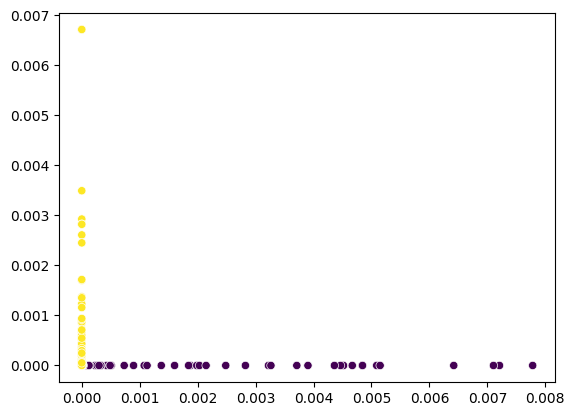

In [5]:
sns.scatterplot(x=similarities[:,0], y=similarities[:,1], c=y)

## Finding the optimal value of $\sigma$

In [6]:
opt_sigma = optimize_width(X_scaled, y, kernel="gaussian")
print("Optimal width:", opt_sigma)

Optimal width: 1.6715580652203976


In [7]:
similarities_opt = generate_similarity_space(X, y, sigma=opt_sigma, kernel="gaussian")

<Axes: >

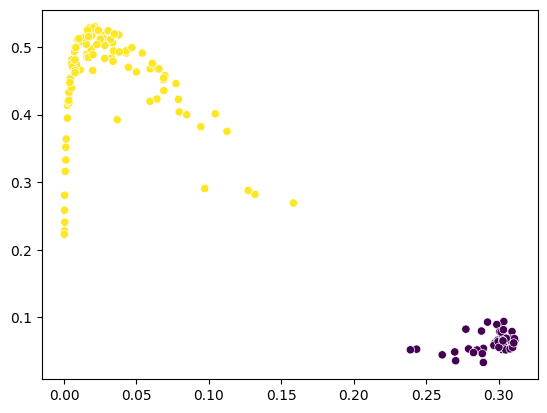

In [8]:
sns.scatterplot(x=similarities_opt[:,0], y=similarities_opt[:,1], c=y)

## Plotting the loss function

In [9]:
sigma_range = np.arange(.01, 3*opt_sigma, .01)
loss_values = np.array(list(map(lambda sigma: similarity_distance_loss(
    X_scaled, y, sigma=sigma, kernel="gaussian"
), sigma_range)))

<Axes: >

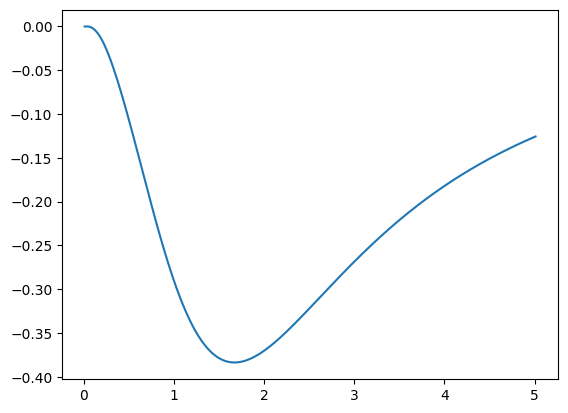

In [10]:
sns.lineplot(x=sigma_range, y=loss_values)

## Training a simple SVM

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def train_and_evaluate_svm(X, y, sigma):
    """
    Splits the dataset into train and test sets, trains an SVM with an RBF kernel using the given sigma,
    and computes the classification report.

    Parameters:
    X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    y (np.ndarray): Label array of shape (n_samples,).
    sigma (float): Hyperparameter controlling the RBF kernel width.

    Returns:
    None
    """
    # Split data into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Compute gamma from sigma: gamma = 1 / (2 * sigma^2)
    gamma = 1 / (2 * sigma**2)

    # Train SVM with RBF kernel
    clf = SVC(kernel="rbf", gamma=gamma)
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    X_test_scaled = scaler.transform(X_test)
    y_pred = clf.predict(X_test_scaled)

    # Compute classification report
    report = classification_report(y_test, y_pred)
    print(report)

In [12]:
train_and_evaluate_svm(X, y, sigma=0.1)

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.69      1.00      0.82        20

    accuracy                           0.70        30
   macro avg       0.84      0.55      0.50        30
weighted avg       0.79      0.70      0.60        30



In [13]:
train_and_evaluate_svm(X, y, sigma=opt_sigma)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        20

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

